In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



In [20]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

spy = spy.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [21]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)


In [22]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

tlt = tlt.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)


In [5]:
# Initial configuration
INITIAL_CAPITAL = 1000000
TREASURY_YIELD = 0.045  # Assuming 4.5% annual yield for 3-month treasury
REBALANCE_THRESHOLD = 0.05  # 5% drift triggers rebalancing

# Initial allocation (starting point)
initial_allocation = {
    'CASH': 0.25,
    'BTC': 0.25,
    'SPY': 0.25,
    'TLT': 0.25
}


In [34]:
def generate_signals(df):
    """Generate trading signals based on SMA crossovers"""
    signals = pd.DataFrame(index=df.index)
    signals['price'] = df['Close']
    
    # SMA crossover signals
    signals['sma5_10'] = np.where(df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close'], 1, -1)
    signals['sma10_15'] = np.where(df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'], 1, -1)
    
    # Combine signals (range: -2 to +2)
    signals['signal'] = signals['sma5_10'] + signals['sma10_15']
    
    # Momentum calculation (optional but valuable)
    signals['momentum'] = df['Close'].pct_change(5)
    
    return signals

#An SMA crossover occurs when one SMA crosses above or below another SMA.
# For example:
# If SMAVG (5) > SMAVG (10), it indicates a short-term bullish trend → Signal = 1.
# If SMAVG (5) ≤ SMAVG (10), it indicates a short-term bearish trend → Signal = -1.
# Similarly:
# If SMAVG (10) > SMAVG (15), it indicates a medium-term bullish trend → Signal = 1.
# If SMAVG (10) ≤ SMAVG (15), it indicates a medium-term bearish trend → Signal = -1.

#The two SMA signals are combined into a single signal:
# Possible values for 'signal':
# +2: Strong bullish trend (sma5_10 = 1 and sma10_15 = 1).
# +1: Mild bullish trend (one SMA signal is bullish, the other is neutral or bearish).
# 0: Neutral trend (the two SMA signals cancel each other out).
# -1: Mild bearish trend.
# -2: Strong bearish trend (sma5_10 = -1 and sma10_15 = -1).



In [27]:
def determine_allocation(cash_rate, btc_signal, spy_signal, tlt_signal, current_allocation):
    """Determine optimal allocation based on technical signals"""
    
    # Base allocation - equal weight
    new_allocation = {
        'CASH': 0.25,
        'BTC': 0.25,
        'SPY': 0.25,
        'TLT': 0.25
    }
    
    # Adjust based on technical signals
    # Scale: -2 (very bearish) to +2 (very bullish)
    
    # SPY adjustment
    if spy_signal['signal'].iloc[-1] == 2:  # Very bullish
        new_allocation['SPY'] = 0.35
        new_allocation['CASH'] = 0.15
    elif spy_signal['signal'].iloc[-1] == -2:  # Very bearish
        new_allocation['SPY'] = 0.15
        new_allocation['CASH'] = 0.35
    
    # BTC adjustment - tends to be more volatile, so slightly more conservative
    if btc_signal['signal'].iloc[-1] == 2:  # Very bullish
        new_allocation['BTC'] = 0.30
    elif btc_signal['signal'].iloc[-1] == -2:  # Very bearish
        new_allocation['BTC'] = 0.15
        new_allocation['CASH'] += 0.05  # Increase cash further
    
    # TLT adjustment - often moves inverse to equities
    if tlt_signal['signal'].iloc[-1] == 2:  # Very bullish
        new_allocation['TLT'] = 0.35
    elif tlt_signal['signal'].iloc[-1] == -2:  # Very bearish
        new_allocation['TLT'] = 0.15
    
    # Special case: if all risk assets are bearish, increase cash significantly
    if all(x['signal'].iloc[-1] < 0 for x in [btc_signal, spy_signal, tlt_signal]):
        new_allocation['CASH'] = 0.40
        # Reduce others proportionally
        factor = 0.60 / sum([new_allocation['BTC'], new_allocation['SPY'], new_allocation['TLT']])
        new_allocation['BTC'] *= factor
        new_allocation['SPY'] *= factor
        new_allocation['TLT'] *= factor
    
    # Normalize to ensure sum = 1
    total = sum(new_allocation.values())
    for key in new_allocation:
        new_allocation[key] /= total
    
    return new_allocation


In [28]:
def handle_btc_off_hours(btc_signal, current_allocation, portfolio_value):
    """Special handling for BTC during weekend/off-hours"""
    new_allocation = current_allocation.copy()
    
    # Only adjust BTC allocation during off-hours based on its signal
    if btc_signal['signal'].iloc[-1] >= 1:  # Bullish
        # Increase BTC slightly (max 5%)
        new_btc = min(current_allocation['BTC'] + 0.05, 0.35)
        adjustment = new_btc - current_allocation['BTC']
        
        # Reduce cash accordingly
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = max(0.10, current_allocation['CASH'] - adjustment)
        
    elif btc_signal['signal'].iloc[-1] <= -1:  # Bearish
        # Decrease BTC slightly
        new_btc = max(current_allocation['BTC'] - 0.05, 0.10)
        adjustment = current_allocation['BTC'] - new_btc
        
        # Increase cash accordingly
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = current_allocation['CASH'] + adjustment
    
    # Normalize to ensure sum = 1
    total = sum(new_allocation.values())
    for key in new_allocation:
        new_allocation[key] /= total
    
    return new_allocation

In [29]:
def rebalance_portfolio(current_allocation, new_allocation, portfolio_value, 
                         rebalance_threshold=REBALANCE_THRESHOLD):
    """Determine if rebalancing is needed and execute if necessary"""
    
    # Check if any allocation differs by more than the threshold
    needs_rebalance = any(
        abs(new_allocation[asset] - current_allocation[asset]) > rebalance_threshold
        for asset in current_allocation
    )
    
    if needs_rebalance:
        # Calculate new holdings based on target allocation
        new_holdings = {
            asset: portfolio_value * new_allocation[asset]
            for asset in new_allocation
        }
        return new_allocation, new_holdings, True
    
    return current_allocation, None, False

In [30]:
def backtest_strategy(start_date, end_date, btc_data, spy_data, tlt_data,
                     initial_capital=INITIAL_CAPITAL):
    """Backtest the four-asset strategy over a date range"""
    
    # Initialize portfolio
    current_allocation = initial_allocation.copy()
    current_holdings = {asset: initial_capital * weight 
                       for asset, weight in current_allocation.items()}
    portfolio_values = []
    allocations_history = []
    
    # Create date range for backtesting
    dates = pd.date_range(start=start_date, end=end_date, freq='30min')
    
    for date in dates:
        is_trading_day = date.weekday() < 5  # Mon-Fri
        is_market_hours = is_trading_day and 9 <= date.hour < 16  # 9am-4pm ET
        
        # Calculate current portfolio value
        portfolio_value = sum(current_holdings.values())
        portfolio_values.append(portfolio_value)
        allocations_history.append(current_allocation.copy())
        
        # Get data available at this timestamp
        btc_data_now = btc_data[btc_data['Date'] <= date]  # BTC trades 24/7
        
        # Only process equity/bond market data during market hours
        if is_market_hours:
            spy_data_now = spy_data[spy_data['Date'] <= date]
            tlt_data_now = tlt_data[tlt_data['Date'] <= date]
            
            if not btc_data_now.empty and not spy_data_now.empty and not tlt_data_now.empty:
                # Generate signals
                btc_signal = generate_signals(btc_data_now.tail(15))
                spy_signal = generate_signals(spy_data_now.tail(15))
                tlt_signal = generate_signals(tlt_data_now.tail(15))
                
                # Determine new allocation
                new_allocation = determine_allocation(
                    TREASURY_YIELD/365, btc_signal, spy_signal, tlt_signal, current_allocation
                )
                
                # Check if rebalancing is needed
                current_allocation, new_holdings, did_rebalance = rebalance_portfolio(
                    current_allocation, new_allocation, portfolio_value
                )
                
                # Update holdings if rebalanced
                if did_rebalance and new_holdings:
                    current_holdings = new_holdings
        
        # Handle BTC during off-hours
        elif not btc_data_now.empty:
            btc_signal = generate_signals(btc_data_now.tail(15))
            
            # Only adjust BTC allocation during off-hours
            new_allocation = handle_btc_off_hours(
                btc_signal, current_allocation, portfolio_value
            )
            
            # Check if BTC rebalancing is needed
            current_allocation, new_holdings, did_rebalance = rebalance_portfolio(
                current_allocation, new_allocation, portfolio_value, 
                rebalance_threshold=0.05  # Slightly higher threshold for off-hours
            )
            
            # Update holdings if rebalanced
            if did_rebalance and new_holdings:
                current_holdings = new_holdings
        
        # Update cash value based on treasury yield (daily compounding)
        daily_yield = (1 + TREASURY_YIELD) ** (1/365) - 1
        current_holdings['CASH'] *= (1 + daily_yield)
    
    return pd.Series(portfolio_values, index=dates), pd.DataFrame(allocations_history, index=dates)



In [31]:
def compare_performance(portfolio_values, benchmark_values):
    """Compare portfolio performance against cash benchmark"""
    
    # Calculate returns
    portfolio_returns = portfolio_values.pct_change().dropna()
    benchmark_returns = benchmark_values.pct_change().dropna()
    
    # Calculate metrics
    metrics = {
        'Total Return': portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1,
        'Benchmark Return': benchmark_values.iloc[-1] / benchmark_values.iloc[0] - 1,
        'Excess Return': (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 
                         (benchmark_values.iloc[-1] / benchmark_values.iloc[0]),
        'Sharpe Ratio': np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std(),
        'Max Drawdown': (portfolio_values / portfolio_values.cummax() - 1).min(),
        'Volatility': portfolio_returns.std() * np.sqrt(252)
    }
    
    return metrics


In [32]:
def plot_portfolio_performance(portfolio_values, benchmark_values, allocation_history):
    """Plot portfolio performance and allocation over time"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot portfolio value vs benchmark
    ax1.plot(portfolio_values, label='Four-Asset Portfolio')
    ax1.plot(benchmark_values, label='Cash Benchmark (3-month Treasury)')
    ax1.set_title('Portfolio Performance')
    ax1.legend()
    
    # Plot allocation over time as stacked area
    ax2.stackplot(allocation_history.index, 
                 [allocation_history['CASH'], 
                  allocation_history['BTC'],
                  allocation_history['SPY'], 
                  allocation_history['TLT']],
                 labels=['Cash', 'BTC', 'SPY', 'TLT'],
                 alpha=0.8)
    ax2.set_title('Portfolio Allocation Over Time')
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()




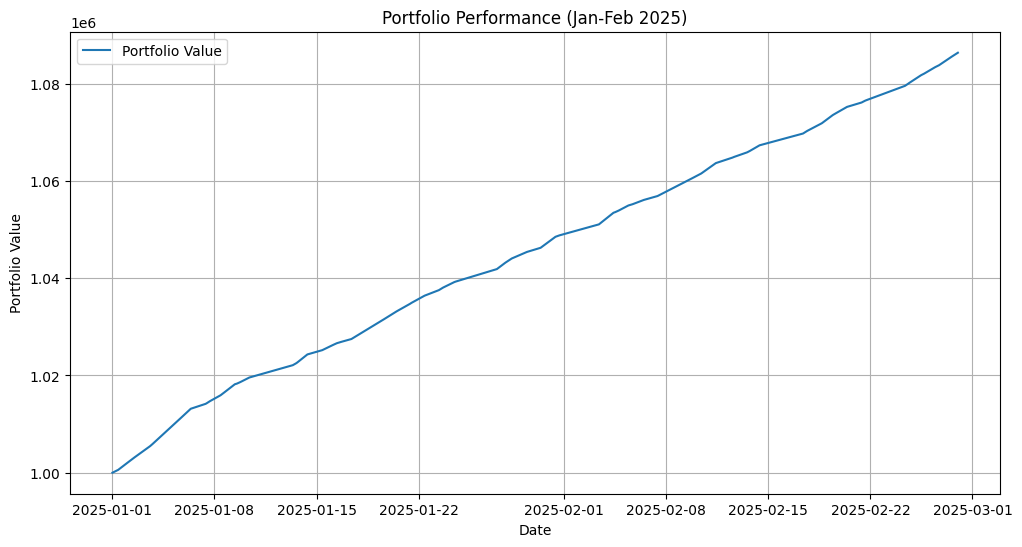

In [35]:
# Define backtest period
start_date = "2025-01-01"
end_date = "2025-02-28"

# Run backtest
portfolio_values, allocations_history = backtest_strategy(
    start_date, end_date, btc, spy, tlt
)

# Plot portfolio performance
plt.figure(figsize=(12,6))
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance (Jan-Feb 2025)")
plt.legend()
plt.grid()
plt.show()



In [23]:
print(btc.columns)
print(spy.columns)
print(tlt.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'SMAVG (5)  on Close',
       'SMAVG (10)  on Close', 'SMAVG (15)  on Close'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'SMAVG (5)  on Close',
       'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'Volume'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'SMAVG (5)  on Close',
       'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'Volume'],
      dtype='object')
